# Predicting Insurance Cross Sell Opportunities

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Importing the dataset

In [4]:
insurance_df = pd.read_csv('data/insurance_cross_sell.csv')
insurance_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
insurance_df.describe().round(2)


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00
mean,190555.00,38.82,1.00,26.39,0.46,30564.39,112.03,154.35,0.12
std,110016.84,15.51,0.05,13.23,0.50,17213.16,54.20,83.67,0.33
min,1.00,20.00,0.00,0.00,0.00,2630.00,1.00,10.00,0.00
25%,95278.00,25.00,1.00,15.00,0.00,24405.00,29.00,82.00,0.00
50%,190555.00,36.00,1.00,28.00,0.00,31669.00,133.00,154.00,0.00
75%,285832.00,49.00,1.00,35.00,1.00,39400.00,152.00,227.00,0.00
max,381109.00,85.00,1.00,52.00,1.00,540165.00,163.00,299.00,1.00


In [6]:
insurance_df.count()

id                      381109
Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

From dataset importing, we can observe that the dataset does not have any missing values. The dataset has 12 features and 381109 observations. The dataset has 8 categorical features and 4 numerical features which are  "ID", "Age", "Annual_Premium", "Vintage". 
The target variable is 'Response' which is a binary variable. 

In [7]:
insurance_df_categorical = insurance_df.drop(["id","Annual_Premium", "Age", "Vintage"],  axis=1).copy()
for column in insurance_df_categorical.columns:
    print(insurance_df_categorical[column].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64
Previously_Insured
0    206481
1  

Moreover the dataset is imbalanced as the number of observations for 'Response' = 1 is 46710 and for 'Response' = 0 is 334399, and other categorical features are also imbalanced (for example, 'Vehicle_Age' has 164786 observations for '< 1 Year' and 200316 observations for '> 2 Years'). This is an important factor to consider while building the model.<br>
It is interesting to observe that the dataset has 2 features 'Policy_Sales_Channel' and 'Region_Code' which have 155 and 53 unique values respectively. This is a large number of unique values for categorical features and would be another challenging point while building the model.<br>
There are 812 buyers who have not a driving license, and just 41 of them are interested in the vehicle insurance. This is a very small number of observations.

In [8]:
responce_with_no_licence = insurance_df[insurance_df["Driving_License"] == 0]["Response"]
print(responce_with_no_licence.value_counts())

#potrebbe trattarsi di una bicicletta o di un monopattino elettrico ad esempio


Response
0    771
1     41
Name: count, dtype: int64


# Data Preprocessing

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, classification_report

def encode_set(dataset, X=np.array([]), label_encoder=LabelEncoder(), one_hot_encoder=None):
    for column in dataset.columns:
        X_tmp = label_encoder.fit_transform(dataset[column])
        X_tmp = X_tmp.reshape(X_tmp.shape[0],1)
        if(one_hot_encoder is not None):
            X_tmp = one_hot_encoder.fit_transform(X_tmp[:,0].reshape(-1,1)).toarray()
        if X.shape[0] == 0:
            X = X_tmp
        else:
            X = np.hstack((X_tmp, X))
        print(f"Categorical feature: {column}, Number of categories: {X_tmp[1,:].shape[0]}")
    return X


def evaluate_model(model, data, scaler=None, train_test_dataset='Train', print_report=False, threshold=0.5):
    '''
    Evaluate model performance on a given dataset. To be used after training the model.
    :param model: trained model
    :param data: tuple of features and labels
    :param scaler: scaler used to scale the features
    :param train_test_dataset: string to identify the dataset
    :param print_report: boolean to print classification report 
    '''
    X_, y_ = data
    if scaler is not None:
        X_ = scaler.transform(X_)

    y_pred_ = model.predict(X_)
    y_pred_proba_ = model.predict_proba(X_)

    if threshold != 0.5:
        y_pred_ = np.where(y_pred_proba_[:,1] > threshold, 1, 0)


    print('Accuracy: {:.3f}'.format(model.score(X_, y_)))
    print(f"Log-Loss: {log_loss(y_, y_pred_proba_):.3f}")
    if print_report:
        print(f"{train_test_dataset} Report:")
        print(classification_report(y_, y_pred_))

In [10]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

X = insurance_df.drop(["id","Response","Gender", "Driving_License", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Policy_Sales_Channel"], axis=1).copy()
print(X.shape)
insurance_df_categorical = insurance_df_categorical.drop("Response", axis=1).copy()
X = encode_set(insurance_df_categorical, X, label_encoder, one_hot_encoder)


(381109, 3)
Categorical feature: Gender, Number of categories: 2
Categorical feature: Driving_License, Number of categories: 2
Categorical feature: Region_Code, Number of categories: 53
Categorical feature: Previously_Insured, Number of categories: 2
Categorical feature: Vehicle_Age, Number of categories: 3
Categorical feature: Vehicle_Damage, Number of categories: 2
Categorical feature: Policy_Sales_Channel, Number of categories: 155


In [11]:
Y = insurance_df["Response"].copy()
Y = label_encoder.fit_transform(Y)
Y

array([1, 0, 1, ..., 0, 0, 0])

In [12]:
RANDOM_SEED = 42
m = X.shape[0]
m_train = int(m * 0.75)
m_test = m - m_train

random_indices = np.random.permutation(m)
X_rand = X[random_indices]
Y_rand = Y[random_indices]

X_training, X_test, Y_training, Y_test = train_test_split(X_rand, Y_rand, test_size =float(m_test)/float(m), random_state = RANDOM_SEED)

print(Y_training)

m_training = X_training.shape[0]
m_test = X_test.shape[0]

#let's see what the fraction of ones in the entire dataset is
print("Fraction of ones in the train set: ", round(float(sum(Y_training))/float(m_training), 3))
print("Fraction of ones in the test set: ", round(float(sum(Y_test))/float(m_test), 3))
print("Fraction of ones in the entire dataset: ", round(float(sum(Y_training)+sum(Y_test))/float(m_training+m_test), 3))


[0 0 0 ... 0 0 0]
Fraction of ones in the train set:  0.123
Fraction of ones in the test set:  0.123
Fraction of ones in the entire dataset:  0.123


In [13]:
std_scaler = StandardScaler()
X_training = std_scaler.fit_transform(X_training)

## Model 1: LogisticRegression with L1

In [14]:
from sklearn.linear_model import LogisticRegression
#log_reg = LogisticRegression(penalty='l1', C=10000, solver='saga', class_weight='balanced')
log_reg = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True)


Accuracy: 0.695
Log-Loss: 0.473
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    250799
           1       0.28      0.94      0.43     35032

    accuracy                           0.70    285831
   macro avg       0.63      0.80      0.61    285831
weighted avg       0.90      0.70      0.75    285831



In [15]:
evaluate_model(log_reg, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

Accuracy: 0.695
Log-Loss: 0.473
Test Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     83600
           1       0.28      0.93      0.43     11678

    accuracy                           0.70     95278
   macro avg       0.63      0.80      0.61     95278
weighted avg       0.90      0.70      0.75     95278



In [16]:
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, RocCurveDisplay, classification_report
y_pred_proba_training = log_reg.predict_proba(X_training)
y_pred_train = log_reg.predict(X_training)
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = log_reg.predict(X_test)

confusion_matrix_train = confusion_matrix(Y_training, y_pred_train)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

print("Confusion matrix for training set:")
print(confusion_matrix_train)
print("Confusion matrix for test set:")
print(confusion_matrix_test)



Confusion matrix for training set:
[[165966  84833]
 [  2241  32791]]
Confusion matrix for test set:
[[ 7727 75873]
 [ 1178 10500]]


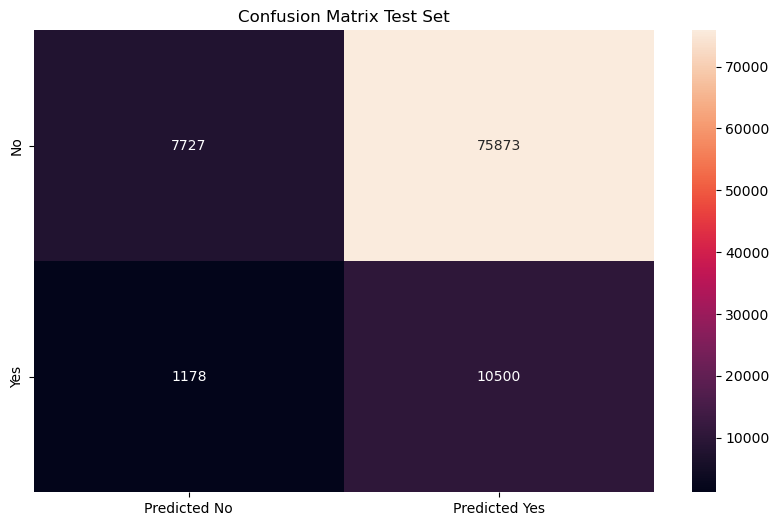

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data=confusion_matrix_test, annot=True, fmt='g')
plt.title("Confusion Matrix Test Set")
ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

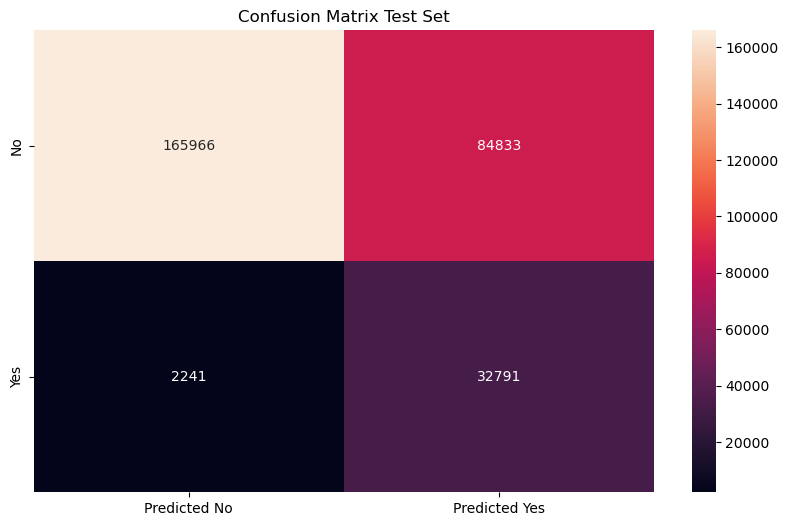

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data=confusion_matrix_train, annot=True, fmt='g')
plt.title("Confusion Matrix Test Set")
ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

## Model 2: LogisticRegression with Cross Validation and polynomial features

In [19]:
from sklearn.linear_model import LogisticRegressionCV


In [20]:
def logistic_regression_CV(X_training, Y_training):
    log_reg_cv = LogisticRegressionCV(Cs=10, cv=10, penalty='l2', class_weight='balanced')
    log_reg_cv.fit(X_training, Y_training)

    print("Values of parameter C tried in 10-fold Cross-Validation: {}".format( log_reg_cv.Cs_ ))
    CV_accuracies = np.divide(np.sum(log_reg_cv.scores_[1],0),10)
    print("Accuracies obtained for the different values of C with 10-fold Cross-Validation: {}".format( CV_accuracies ))

    print("Best value C according to 10-fold Cross-Validation: {}".format( log_reg_cv.C_[0] ))

    # let's store the best CV accuracy, and then print it
    print(log_reg_cv.scores_[1])
    regL2_best_CV_accuracy = np.max(log_reg_cv.scores_[1])
    print("10-fold Cross-Validation accuracies obtained with the best value of parameter C: {}".format( regL2_best_CV_accuracy ))

    regL2_full = LogisticRegression(C = log_reg_cv.C_[0], penalty='l2', class_weight='balanced')


    #fit the model using the best C on the entire training set
    regL2_full.fit(X_training, Y_training)


    evaluate_model(regL2_full, (X_training, Y_training), print_report=True)
    return regL2_full


Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.69312985 0.69404647 0.69491762 0.69501208 0.69503307 0.69501908
 0.69501908 0.69501558 0.69501558 0.69502258]
Best value C according to 10-fold Cross-Validation: 0.3593813663804626
[[0.6959138  0.69647355 0.69692835 0.69713826 0.69724321 0.69720823
  0.69720823 0.69720823 0.69720823 0.69720823]
 [0.69236959 0.69320925 0.6945737  0.69464367 0.69467866 0.69467866
  0.69467866 0.69467866 0.69467866 0.69467866]
 [0.69257951 0.69191477 0.69257951 0.69264948 0.69264948 0.69264948
  0.69264948 0.69264948 0.69264948 0.69264948]
 [0.68757653 0.68897596 0.69023545 0.69020047 0.69016548 0.6901305
  0.6901305  0.6901305  0.6901305  0.6901305 ]
 [0.69303432 0.69460868 0.69572823 0.69590316 0.69597313 0.695973

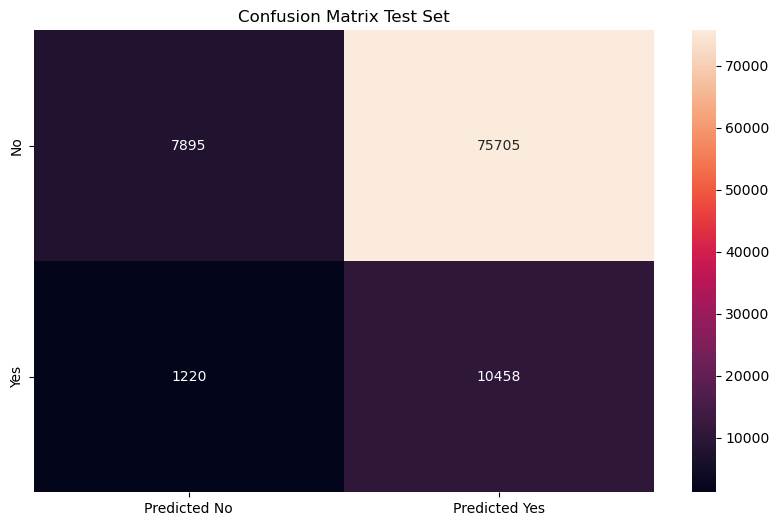

In [21]:
regL2_full = logistic_regression_CV(X_training, Y_training)

evaluate_model(regL2_full, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

y_pred_proba_test = regL2_full.predict_proba(X_test)
y_pred_test = regL2_full.predict(X_test)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(data=confusion_matrix_test, annot=True, fmt='g')
plt.title("Confusion Matrix Test Set")
ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

## Rimuovo samples per ribalanciare il dataset


In [84]:
df = pd.read_csv('data/insurance_cross_sell.csv')

df = df.drop(['id'], axis=1)

print(df['Response'].value_counts())

df = df.groupby('Policy_Sales_Channel').filter(lambda x: len(x)> 100)

idx = df[df['Response'] == 0].index
np.random.seed(RANDOM_SEED)
idx_to_remove = np.random.choice(idx, int(len(idx)*0.5), replace=False)

df = df.drop(idx_to_remove)
print(df.shape)
print(df['Response'].value_counts())

df.index = range(len(df))

idx = df[df['Response'] == 1].index
np.random.seed(RANDOM_SEED)
idx_to_add = np.random.choice(idx, int(len(idx)*0.5), replace=False)

samples_to_add = df.iloc[idx_to_add.tolist()]
print(len(idx_to_add))
print(samples_to_add.shape)

df = pd.concat([df, samples_to_add], ignore_index=True)


print(df['Response'].value_counts())


Response
0    334399
1     46710
Name: count, dtype: int64
(212764, 11)
Response
0    166297
1     46467
Name: count, dtype: int64
23233
(23233, 11)
Response
0    166297
1     69700
Name: count, dtype: int64


In [90]:
X = df.drop(["Response","Gender", "Driving_License", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Policy_Sales_Channel"], axis=1).copy()
print(X.shape)
df_categorical = df.drop(["Region_Code", "Gender", "Policy_Sales_Channel", "Annual_Premium", "Age", "Vintage"],  axis=1).copy()
df_categorical = df_categorical.drop("Response", axis=1).copy()
X = encode_set(df_categorical, X, label_encoder) #,one_hot_encoder
Y = df["Response"].copy()

RANDOM_SEED = 42
m = X.shape[0]
m_train = int(m * 0.75)
m_test = m - m_train

random_indices = np.random.permutation(m)
X_rand = X[random_indices]
Y_rand = Y[random_indices]

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size =float(m_test)/float(m))

m_training = X_training.shape[0]
m_test = X_test.shape[0]

print(df["Policy_Sales_Channel"].value_counts())


(235997, 3)
Categorical feature: Driving_License, Number of categories: 1
Categorical feature: Previously_Insured, Number of categories: 1
Categorical feature: Vehicle_Age, Number of categories: 1
Categorical feature: Vehicle_Damage, Number of categories: 1
Policy_Sales_Channel
152.0    71390
26.0     55518
124.0    51107
160.0    11413
156.0     7590
         ...  
140.0       63
135.0       56
119.0       56
127.0       55
113.0       51
Name: count, Length: 62, dtype: int64


In [91]:
std_scaler = StandardScaler()
X_training = std_scaler.fit_transform(X_training)
X_test = std_scaler.transform(X_test)

In [92]:
log_reg = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True)

Accuracy: 0.705
Log-Loss: 0.478
Train Report:
              precision    recall  f1-score   support

           0       0.98      0.59      0.74    124872
           1       0.50      0.98      0.66     52125

    accuracy                           0.71    176997
   macro avg       0.74      0.78      0.70    176997
weighted avg       0.84      0.71      0.72    176997



In [88]:
evaluate_model(log_reg, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

Accuracy: 0.705
Log-Loss: 0.641
Test Report:
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     41642
           1       0.50      0.98      0.66     17358

    accuracy                           0.70     59000
   macro avg       0.74      0.78      0.70     59000
weighted avg       0.84      0.70      0.72     59000



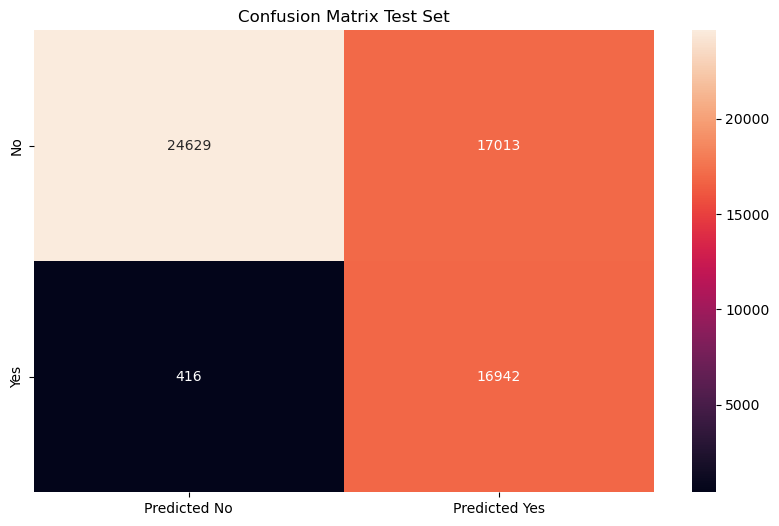

In [89]:
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.5, 1, 0)

confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)


plt.figure(figsize=(10, 6))
ax = sns.heatmap(data=confusion_matrix_test, annot=True, fmt='g')
plt.title("Confusion Matrix Test Set")
ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [45]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_training_poly = poly.fit_transform(X_training)
regL2_full = logistic_regression_CV(X_training_poly, Y_training)



/home/enrico/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/enrico/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.74363446 0.73961321 0.73841479 0.7381592  0.73810241 0.73810809
 0.73810809 0.73810809 0.73810809 0.73810809]
Best value C according to 10-fold Cross-Validation: 0.0001
[[0.73760436 0.7332311  0.73186801 0.7319816  0.73169762 0.73169762
  0.73169762 0.73169762 0.73169762 0.73169762]
 [0.7435679  0.74050094 0.73936503 0.73930823 0.73902425 0.73902425
  0.73902425 0.73902425 0.73902425 0.73902425]
 [0.74243199 0.74044414 0.73930823 0.73896746 0.73902425 0.73896746
  0.73896746 0.73896746 0.73896746 0.73896746]
 [0.74720282 0.74294315 0.74163685 0.74158005 0.74152326 0.74152326
  0.74152326 0.74152326 0.74152326 0.74152326]
 [0.74549895 0.74135287 0.73913784 0.73879707 0.73874027 0.73885386
  0.7388

In [46]:
X_test_poly = poly.fit_transform(X_test)
evaluate_model(regL2_full, (X_test_poly, Y_test), train_test_dataset='Test', print_report=True)


Accuracy: 0.744
Log-Loss: 0.467
Test Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     41231
           1       0.54      0.92      0.68     17458

    accuracy                           0.74     58689
   macro avg       0.75      0.79      0.73     58689
weighted avg       0.83      0.74      0.76     58689



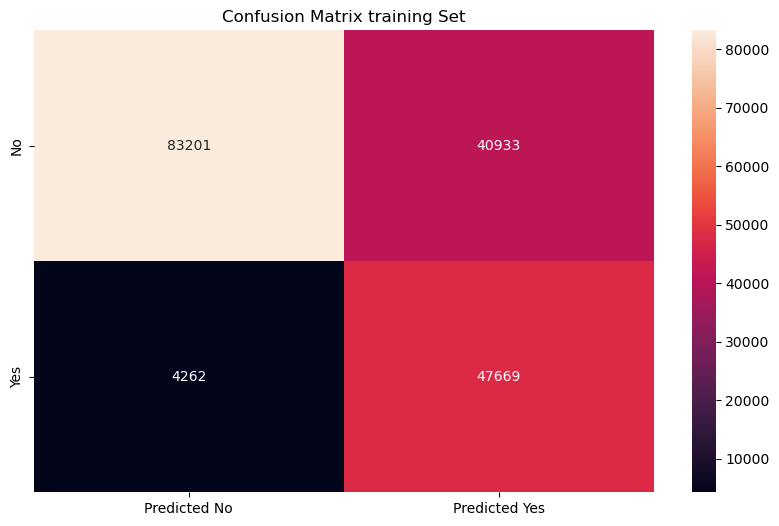

In [47]:
y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
y_pred_training = regL2_full.predict(X_training_poly)
confusion_matrix_training = confusion_matrix(Y_training, y_pred_training)


plt.figure(figsize=(10, 6))
ax = sns.heatmap(data=confusion_matrix_training, annot=True, fmt='g')
plt.title("Confusion Matrix training Set")
ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

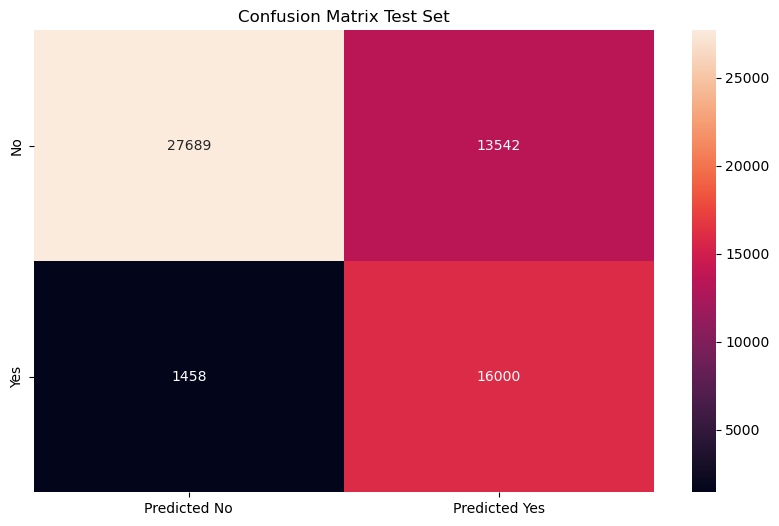

In [55]:
y_pred_proba_test = regL2_full.predict_proba(X_test_poly)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.5, 1, 0)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)


plt.figure(figsize=(10, 6))
ax = sns.heatmap(data=confusion_matrix_test, annot=True, fmt='g')
plt.title("Confusion Matrix Test Set")
ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [ ]:
print(y_pred_proba_test) 


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
